In [35]:
from pettingzoo.classic import connect_four_v3

In [36]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

# Using the PettingZoo environment

This notebook provides smalls chunks of code to get you started with the Connect4 project. You do not have to use this code in you final file, but you can if you wish to. 

In [37]:
env = connect_four_v3.env(render_mode="rgb_array")

env.reset()

# The main difference with the standard gym api is the way the environment is queried. The `step` method return `None`. To get the data on the environment, use the `last` method
state, reward, terminated, truncated, info = env.last()

# state is a dictionary with two keys: observation and action_mask
print(
    state["observation"].shape
)  # Observation is a numpy array with three coordinates, indicating the positions of the pieces of of player 0 and 1 on the the board
print(state["observation"][:, :, 0])  # Where the pieces of player 0 are
print(state["observation"][:, :, 1])  # Where the pieces of player 1 are

print(state["action_mask"])  # an array showing whether the actions are legal or nots


(6, 7, 2)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[1 1 1 1 1 1 1]


In [38]:
env.reset()
env.step(0)

state, reward, terminated, truncated, info = env.last()

print(
    state["observation"].shape
) 
print(state["observation"][:, :, 0])  
print(state["observation"][:, :, 1])  

print(state["action_mask"])

(6, 7, 2)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[1 1 1 1 1 1 1]


# Agents

Here are some implementations of trivial agents that you should be able to beat ultimately. 

In [39]:
class RandomPlayer:
    def __init__(self, rng=None):
        if rng is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = rng

        self.name = "Random Player"

    def get_epsilon_greedy_action(self, obs, epsilon=None):
        obs_mask = obs['action_mask']
        return self.random_choice_with_mask(np.arange(7), obs_mask)

    def random_choice_with_mask(self, arr, mask):
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        if masked_arr.count() == 0:
            return None
        return self.rng.choice(masked_arr.compressed())

In [40]:
class PlayLeftmostLegal:
    def __init__(self):
        self.name = "Left Player"

    def get_epsilon_greedy_action(self, obs, epsilon=None):
        obs_mask = obs['action_mask']
        for i, legal in enumerate(obs_mask):
            if legal:
                return i
        return None

# Running a game


The following function runs a full game between the two agents. 

In [41]:
def play_game(env, agent0, agent1, display=False):
    done = False
    env.reset()
    obs, _, _, _, _ = env.last()
    while not done:
        for i, agent in enumerate([agent0, agent1]):
            action = agent.get_epsilon_greedy_action(obs, epsilon=0)
            env.step(action)
            if display:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            obs, reward, terminated, _, _ = env.last()
            done = terminated
            if np.sum(obs["action_mask"]) == 0:
                if display: 
                    print('Draw')
                return 0.5
            if done:
                if display:
                    print(f"Player {i}: {agent.name} won")
                    print(obs['observation'][:, :, 0]- obs['observation'][:, :, 1])
                return i

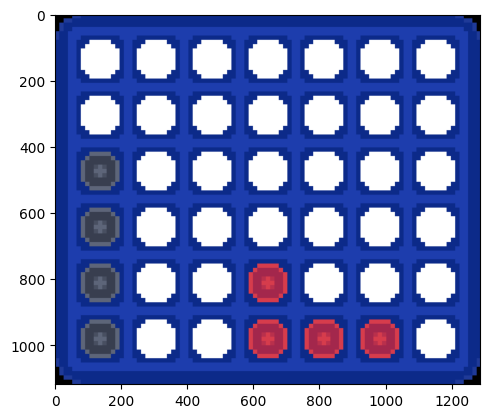

Player 1: Left Player won
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0 -1  0  0  0]
 [ 1  0  0 -1 -1 -1  0]]


1

In [42]:
agent0 = RandomPlayer()
agent1 = PlayLeftmostLegal()

play_game(env, agent0, agent1, display=True)

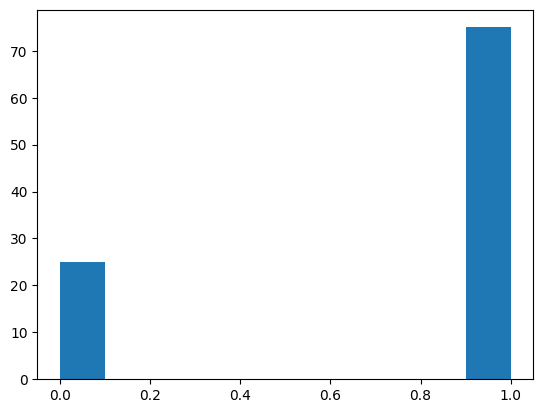

In [43]:
plt.hist([play_game(env, agent0, agent1, display=False) for _ in range(100)])
plt.show()

# Emulating a Gym environment

If we fix the opposite policy, the game from the point of view of the agent is equivalent to a Gym environment. The following class implements this simulation. Then any algorithm that would work in a gym environment with the same observations will work here. 

Note that we implemented the possibility to be the first or the second player. 

In [44]:
class EnvAgainstPolicy: 
    def __init__(self, env, policy, first_player=True):
        self.policy = policy
        self.env = env
        self.first_player = first_player
        self.reset()

    def step(self, action):
        self.env.step(action)
        obs, reward, terminated, _, _ = self.env.last()
        if terminated: 
            self.last_step = obs, reward, True, False, {}
        else: 
            action = self.policy.get_epsilon_greedy_action(obs)
            self.env.step(action)
            obs, reward, terminated, _, _ = self.env.last()
            self.last_step = obs, -reward, terminated, False, {}
        return self.last_step

    def reset(self):
        self.env.reset()
        if not(self.first_player): 
            obs, _, _, _, _ = self.env.last()
            action = self.policy.get_epsilon_greedy_action( obs)
            self.env.step(action)

        self.last_step = self.env.last()
        return self.last_step

    def last(self):
        return self.last_step

# Evaluating an agent against a fixed policy: 

Using the environment above, we can evaluate the agent against this fixed policy. 

In [45]:
def eval_against_policy(env, agent, policy, N_episodes=10, first_player=True):
    eval_env = EnvAgainstPolicy(env, policy, first_player=first_player)
    results = []
    for _ in range(N_episodes):
        done = False
        eval_env.reset()
        obs, _, _, _, _ = eval_env.last()
        while not done:
            action = agent.get_epsilon_greedy_action(obs)
            eval_env.step(action)
            obs, reward, done, _, _ = eval_env.last()
        results.append(reward)
    return results

We can see that if both players play randomly, there is a small but significant advantage to the first player. 

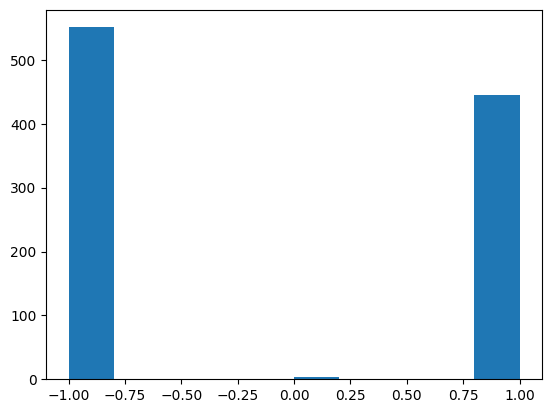

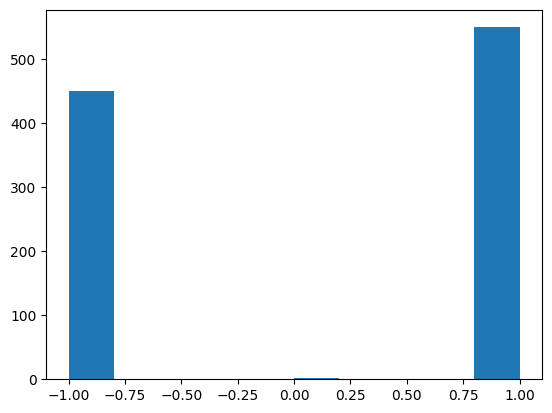

In [46]:
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=False))
plt.show()
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=True))
plt.show()

# Your turn 

Try to build a decent agent. Be creative! You can try any idea that you have: the grade is not about performance of the agent, but more about illustrating phenomena happening in Reinforcement Learning for turn-based games. It's okay to 'help' the agent in any way, as long as it follows the ideas of RL (i.e., as long as there is some learning involved).




In [47]:
mask = np.array([1,1,0]*3)
legal_actions = np.where(mask > 0)[0]
print(legal_actions)
np.random.choice(legal_actions)

[0 1 3 4 6 7]


6

In [49]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
import random
import tqdm
import time
# Define the state space
STATE_SHAPE = (6, 7)

# Define the action space
ACTION_SIZE = 7
ACTION_SPACE = [i for i in range(ACTION_SIZE)]

# Define the parameters for the DQN algorithm
BATCH_SIZE = 8 
GAMMA = 0.99
EPSILON = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
LEARNING_RATE = 0.001
TARGET_UPDATE_FREQ = 100

env = connect_four_v3.env(render_mode="rgb_array")

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_shape, num_actions, alpha=0.001, gamma=0.95, epsilon=0.1, epsilon_decay=0.995, min_epsilon=0.01, memory_size=100, batch_size=32):
        self.name = 'DQN Player'
        
        self.state_shape = state_shape
        self.num_actions = 7
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.memory_size = memory_size
        self.batch_size = batch_size
        
        self.memory = []
        self.model = self.build_model()
        self.target_model = self.build_model()
    
    def build_model(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=STATE_SHAPE),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(7, activation='softmax')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.alpha), loss='mse')
        return model
    
    def get_epsilon_greedy_action(self, state, mask):
        # Mask the Q-values for illegal actions
        q_values = np.array(self.model.predict(np.array(state).reshape(1, *self.state_shape),verbose = 0)[0]) 
        #print(q_values)
        
        # Choose the action with the highest Q-value among the legal actions
        legal_actions = np.where(mask > 0)[0]
        #print(legal_actions)
        if len(legal_actions) == 0:
            print('No legal moves')
            time.sleep(4)
            return None
        else:
            return np.argmax(q_values[legal_actions])

    def get_epsilon_greedy_action(self, obs):
        state = obs['observation'][:, :, 0]- obs['observation'][:, :, 1]
        mask = obs['action_mask']
        
        if random.random() < self.epsilon:
            # Choose a random action among the legal actions
            legal_actions = np.where(mask > 0)[0]
            return np.random.choice(legal_actions)
        else:
            # Choose the action with the highest Q-value among the legal actions
            return self.get_epsilon_greedy_action(state, mask)
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.memory_size:
            self.memory.pop(0)
            
    def experience_replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states = []
        q_values = []
        for state, action, reward, next_state, done in batch:
            s = state['observation'][:, :, 0]- state['observation'][:, :, 1]
            target = self.target_model.predict(np.array(s).reshape(1, *self.state_shape),verbose = 0)[0]
            #print("------------------------------------------",target)
            if done:
                target[action] = reward
            else:
                ns = next_state['observation'][:, :, 0]- next_state['observation'][:, :, 1]
                next_q_values = self.target_model.predict(np.array(ns).reshape(1, *self.state_shape),verbose = 0)[0]
                target[action] = reward + self.gamma * np.max(next_q_values)
            states.append(s)
            q_values.append(target)
        self.model.fit(np.array(states), np.array(q_values), batch_size=self.batch_size, verbose=0)
        
    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights())
        
    def decay_epsilon(self):
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay
    
    def train(self, num_episodes):
        for episode in tqdm.tqdm(range(num_episodes)):
            rn = random.randint(0,1)
            rb = random.randint(0,1)
            if rn == 0:
                eval_env = EnvAgainstPolicy(env, PlayLeftmostLegal(), first_player=rb)
            else:
                eval_env = EnvAgainstPolicy(env, RandomPlayer(), first_player=rb)
            eval_env.reset()
            done = False
            obs, _, _, _, _ = eval_env.last()
            
            while not done:
                action = self.get_epsilon_greedy_action(obs)
                #print(action)
                eval_env.step(action)
                #clear_output(wait=True)
                #plt.imshow(env.render())
                #plt.show()
                #print(len(eval_env.last()))
                next_state, reward, done, _ ,_ = eval_env.last()
                self.remember(obs, action, reward, next_state, done)
                obs = next_state
                #print(state)
                self.experience_replay()
                self.update_target_network()
                self.decay_epsilon()

In [ ]:
agent = DQNAgent(STATE_SHAPE,ACTION_SIZE)

agent.train(100)
# Save the entire model as a SavedModel.
!mkdir -p saved_model
agent.model.save('saved_model/dqn')

 13%|█▎        | 13/100 [03:13<29:34, 20.40s/it]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
 18%|█▊        | 18/100 [06:23<49:11, 36.00s/it]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
 21%|██        | 21/100 [07:43<39:32, 30.04s/it]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
 22%|██▏       | 22/100 [08:37<48:02, 36.96s/it]WARNING:pettingzoo.utils.env_logger:[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
 24%|██▍       | 24/100 [09:30<40:12, 31.74s/it]WARNING:pettingz

In [ ]:
import time
def play_game(env, agent0, agent1, display=False):
    done = False
    env.reset()
    obs, _, _, _, _ = env.last()
    while not done:
        time.sleep(2)
        for i, agent in enumerate([agent0, agent1]):
            print("legal moves :" ,obs['action_mask'])
            action = agent.get_epsilon_greedy_action( obs)
            print("action" ,action)
            env.step(action)
            if display:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            obs, reward, terminated, _, _ = env.last()
            done = terminated
            if np.sum(obs["action_mask"]) == 0:
                if display: 
                    print(obs["action_mask"])
                    print('Draw')
                return 0.5
            if done:
                if display:
                    print(f"Player {i}: {agent.name} won")
                    print(obs['observation'][:, :, 0]- obs['observation'][:, :, 1])
                return i

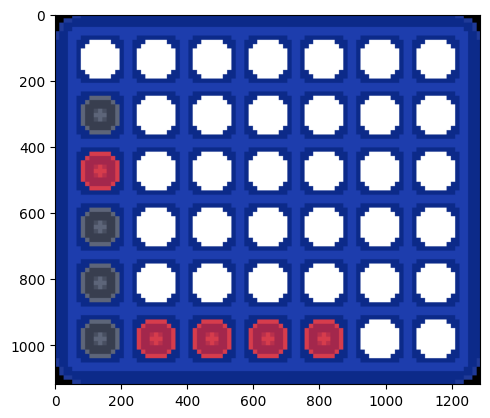

Player 0: DQN Player won
[[ 0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]
 [-1  1  1  1  1  0  0]]


0

In [ ]:
play_game(env,agent, PlayLeftmostLegal(),True)

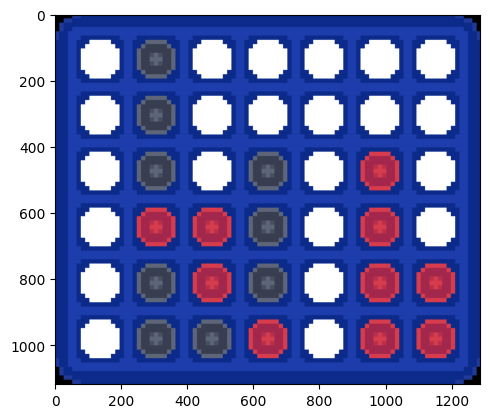

Player 0: Random Player won
[[ 0 -1  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0]
 [ 0 -1  0 -1  0  1  0]
 [ 0  1  1 -1  0  1  0]
 [ 0 -1  1 -1  0  1  1]
 [ 0 -1 -1  1  0  1  1]]


0

In [ ]:
play_game(env, RandomPlayer(), agent, True)

obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.


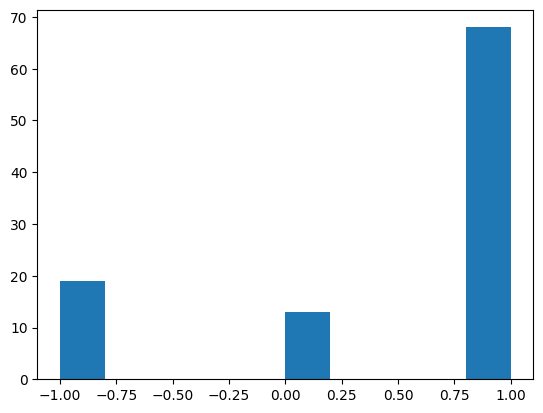

obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.
obs['action_mask'] contains a mask of all legal moves that can be chosen.


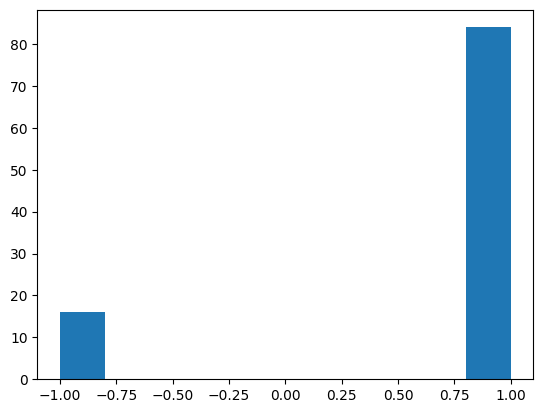

In [ ]:
plt.hist(eval_against_policy(env, agent, RandomPlayer(), N_episodes=100, first_player=False))
plt.show()
plt.hist(eval_against_policy(env, agent, RandomPlayer(), N_episodes=100, first_player=True))
plt.show()

In [ ]:
plt.hist(eval_against_policy(env, agent, PlayLeftmostLegal(), N_episodes=100, first_player=False))
plt.show()
plt.hist(eval_against_policy(env, agent, PlayLeftmostLegal(), N_episodes=100, first_player=True))
plt.show()

NameError: name 'eval_against_policy' is not defined